In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt

# Usamos github porque con drive/data local u otros metodos no funcionaba correctamente del todo
url = 'https://raw.githubusercontent.com/grazuc/Diabetes_csv/main/diabetes_012_health_indicators_BRFSS2015.csv'
diabetes_data = pd.read_csv(url)




# Limpieza y Normalización de datos

En esta sección se limpia el dataset eliminando valores nulos, se reduce el tamaño del dataset para propósitos de visualización, se normalizan los datos y se aplican algoritmos de clustering (K-means) para identificar grupos en los datos.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


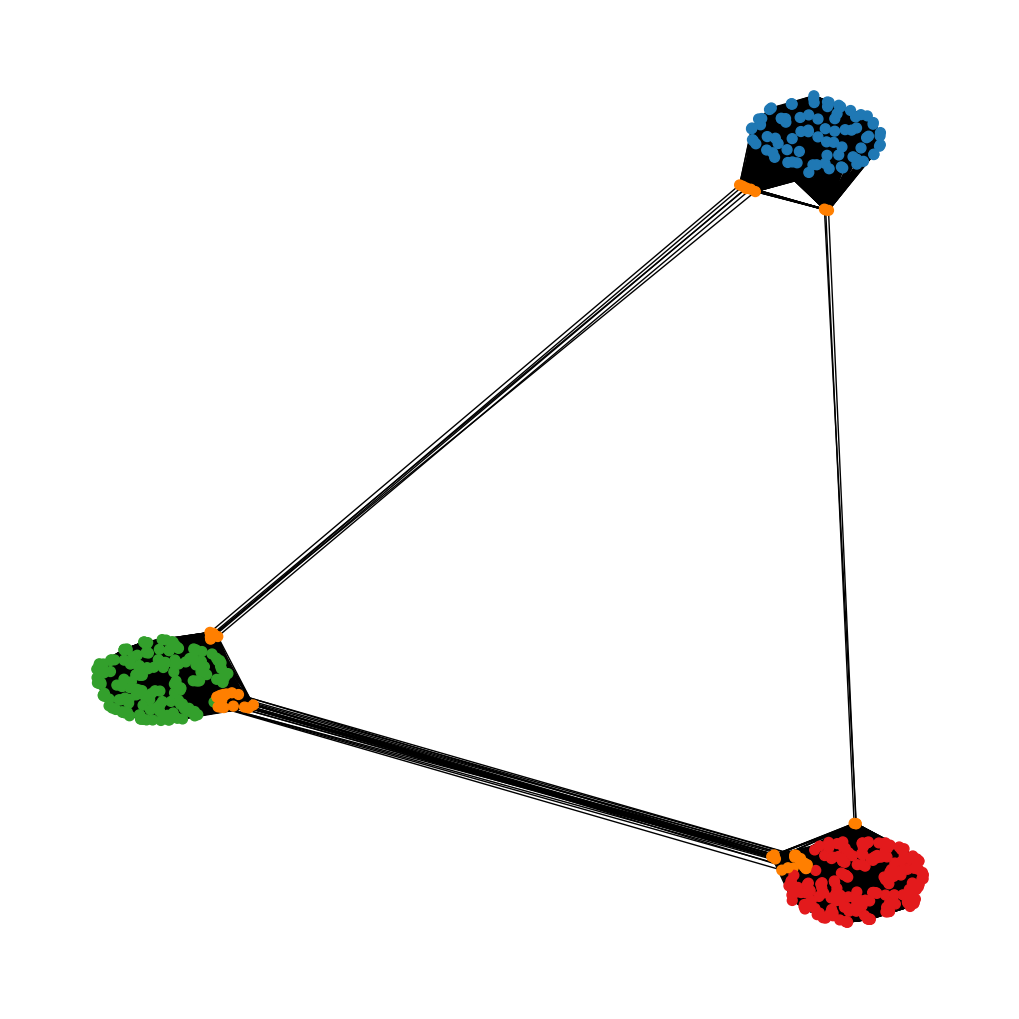

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

# Removiendo nulos
diabetes_data_cleaned = diabetes_data.dropna()

# Achicamos el dataset por cuestiones de visualización (2000 max)
subset_size = 500
diabetes_subset = diabetes_data_cleaned.head(subset_size)

# Normalización de datos
scaler = StandardScaler()
diabetes_subset_scaled = scaler.fit_transform(diabetes_subset)

# Convertimos de vuelta a DataFrame porque el manejo es más fácil
diabetes_subset_scaled = pd.DataFrame(diabetes_subset_scaled, columns=diabetes_subset.columns)

# Aplicamos k-means con un numero de clusters fijo (elegimos 3)
kmeans = KMeans(n_clusters=3, random_state=42)
diabetes_subset_scaled['Cluster'] = kmeans.fit_predict(diabetes_subset_scaled)

# Creación del mapa de partición
partition_map = {index: row['Cluster'] for index, row in diabetes_subset_scaled.iterrows()}

# Creación de un grafo con NetworkX para visualizar las relaciones entre nodos
G = nx.Graph()

# Colores por cluster
cluster_colors = {0: '#1f78b4', 1: '#33a02c', 2: '#e31a1c'}

# Agregado de nodos con colores por cluster
for node, cluster in partition_map.items():
    G.add_node(node, cluster=cluster, color=cluster_colors[cluster])

# Agregado de arcos entre nodos del mismo cluster
for node1, cluster1 in partition_map.items():
    for node2, cluster2 in partition_map.items():
        if node1 < node2 and cluster1 == cluster2:
            G.add_edge(node1, node2, color='black')

# Guardar nodos en arreglos según su cluster
cluster_1 = [node for node, cluster in partition_map.items() if cluster == 0]
cluster_2 = [node for node, cluster in partition_map.items() if cluster == 1]
cluster_3 = [node for node, cluster in partition_map.items() if cluster == 2]

# Extraer datos de los nodos de cada cluster
data_cluster_1 = diabetes_subset_scaled.loc[cluster_1].drop(columns=['Cluster'])
data_cluster_2 = diabetes_subset_scaled.loc[cluster_2].drop(columns=['Cluster'])
data_cluster_3 = diabetes_subset_scaled.loc[cluster_3].drop(columns=['Cluster'])

# Calcular la similitud por coseno entre los nodos de cada par de clusters
cosine_similarities_12 = cosine_similarity(data_cluster_1, data_cluster_2)
cosine_similarities_13 = cosine_similarity(data_cluster_1, data_cluster_3)
cosine_similarities_23 = cosine_similarity(data_cluster_2, data_cluster_3)

# Agregar arcos basados en similitud por coseno mayor y colorear los nodos conectados

G_community = nx.Graph()
similarity_threshold = 0.7

def add_edges_based_on_similarity(cluster1, cluster2, cluster3, similarities_12, similarities_13, G, G_community, similarity_threshold=0.78):
    for i, node_cluster_1 in enumerate(cluster1):
        for j, node_cluster_2 in enumerate(cluster2):
            if similarities_12[i, j] > similarity_threshold:
                if not G.has_edge(node_cluster_1, node_cluster_2):
                    G_community.add_node(node_cluster_1)
                    G_community.add_node(node_cluster_2)
                    G_community.add_edge(node_cluster_1, node_cluster_2, color='black')

                    G.add_edge(node_cluster_1, node_cluster_2, color='black')
                    G.nodes[node_cluster_1]['color'] = '#ff7f00'
                    G.nodes[node_cluster_2]['color'] = '#ff7f00'

        for k, node_cluster_3 in enumerate(cluster3):
            if similarities_13[i, k] > similarity_threshold:
                if not G.has_edge(node_cluster_1, node_cluster_3):
                    G_community.add_node(node_cluster_1)
                    G_community.add_node(node_cluster_3)
                    G_community.add_edge(node_cluster_1, node_cluster_3, color='black')

                    G.add_edge(node_cluster_1, node_cluster_3, color='black')
                    G.nodes[node_cluster_1]['color'] = '#ff7f00'
                    G.nodes[node_cluster_3]['color'] = '#ff7f00'


add_edges_based_on_similarity(cluster_1, cluster_2, cluster_3, cosine_similarities_12, cosine_similarities_13, G, G_community)
add_edges_based_on_similarity(cluster_2, cluster_3, cluster_1, cosine_similarities_23, cosine_similarities_12.T, G, G_community)
add_edges_based_on_similarity(cluster_3, cluster_1, cluster_2, cosine_similarities_13.T, cosine_similarities_23.T, G, G_community)
add_edges_based_on_similarity(cluster_3, cluster_2, cluster_1, cosine_similarities_23.T, cosine_similarities_13.T, G, G_community)


# Visualización del grafo de la comunidad
#pos_community = nx.spring_layout(G_community)
#plt.figure(figsize=(10, 10))
#nx.draw(G_community, pos_community, node_size=50)
#plt.show()

# Obtener los colores de los nodos para la visualización
node_colors = [G.nodes[node].get('color', cluster_colors[partition_map[node]]) for node in G.nodes()]
# Obtener los colores de los arcos para la visualización
edge_colors = [G.edges[edge].get('color', 'black') for edge in G.edges()]

# Visualización del grafo final
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_color=node_colors, edge_color=edge_colors, node_size=50)
plt.show()


##En la figura de arriba se puede visualizar el grafo creado usando NetworkX para visualizar las relaciones entre los datos dentro de los mismos clusters. Se añadieron nodos y enlaces entre nodos que pertenecen al mismo cluster, y se generó una visualización del grafo.

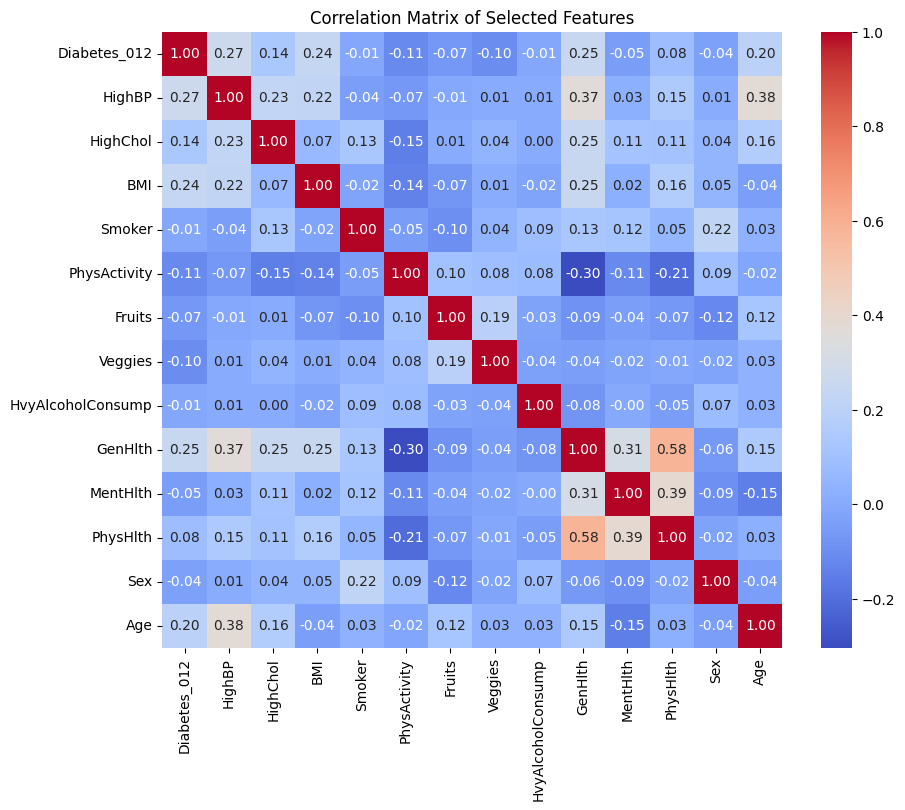

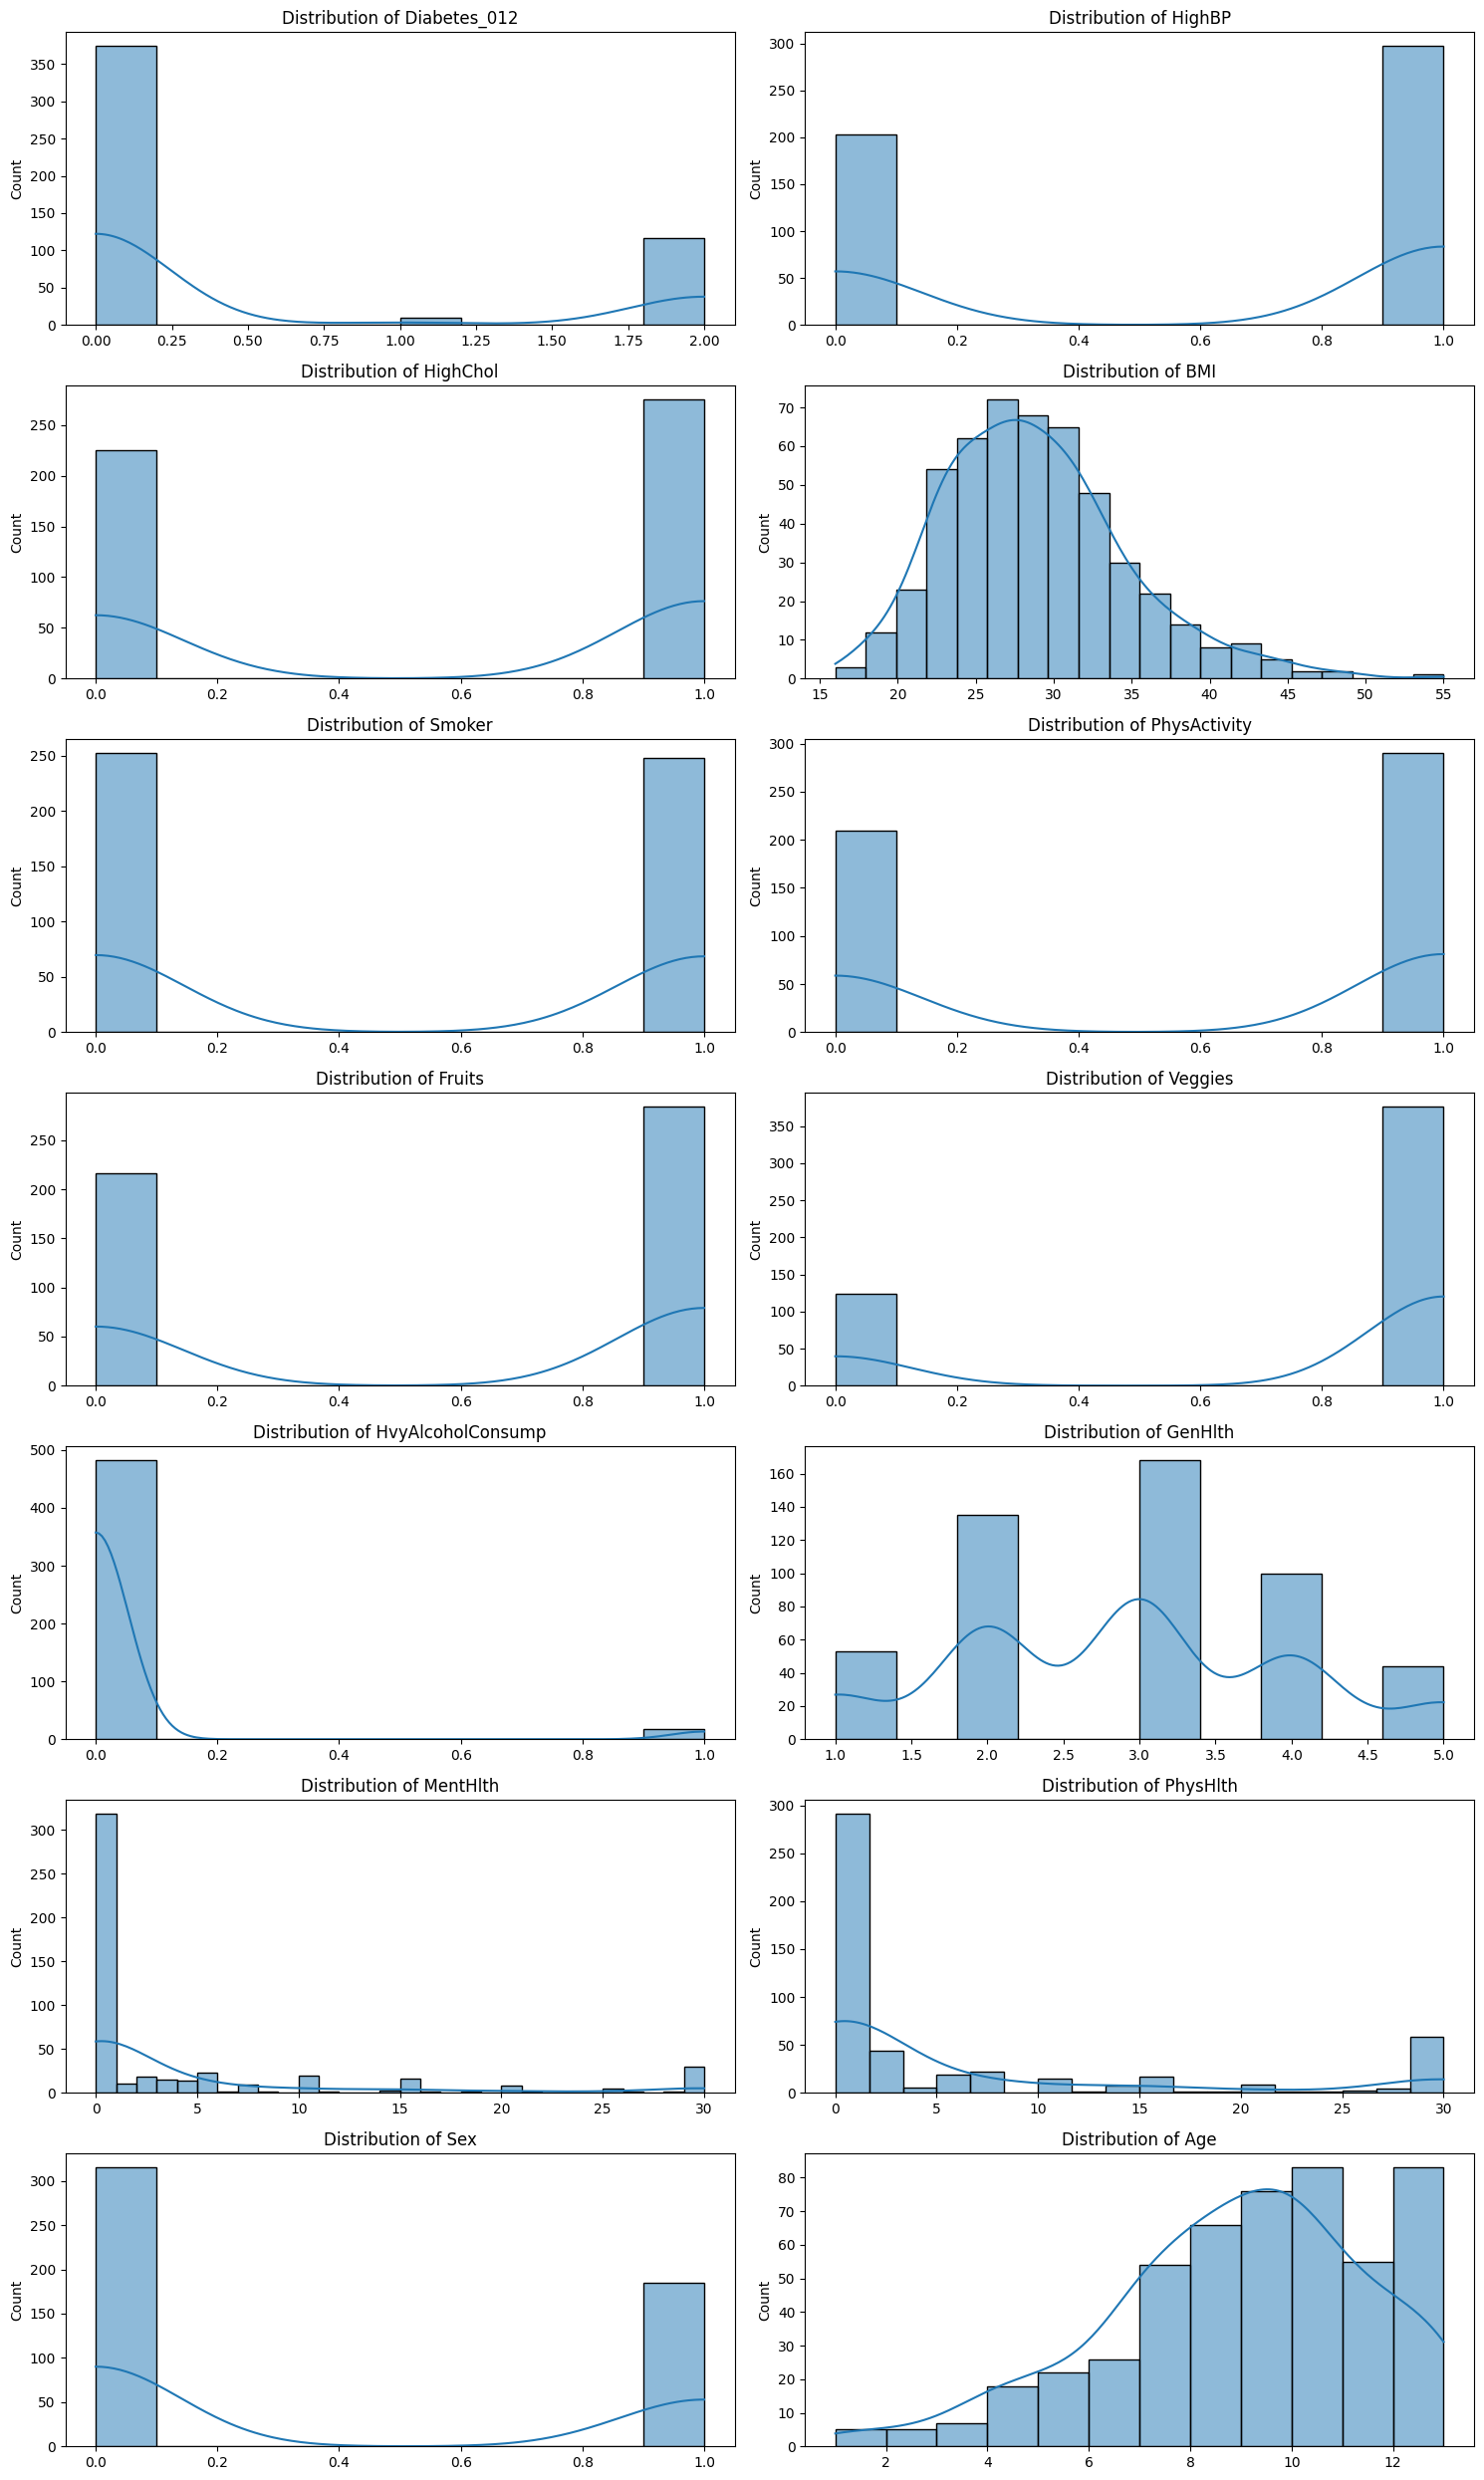

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Analizar la distribución y relaciones de las características elegidas (se pueden modificar)
selected_features = ['Diabetes_012', 'HighBP', 'HighChol', 'BMI', 'Smoker',
    'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
    'GenHlth', 'MentHlth', 'PhysHlth', 'Sex', 'Age']

# Filtrar el dataset para incluir solo las características seleccionadas
diabetes_subset_features = diabetes_subset[selected_features]

# Correlaciones entre las características
correlation_matrix = diabetes_subset_features.corr()

# Visualizar la matriz de correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Selected Features')
plt.show()

# Ajustar el número de subgráficos para que coincida con el número de características
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 25))  # Modificar acá si se agregan/eliminan caracteristicas
axes = axes.flatten()  # Aplanar el array para iterar fácilmente

for i, col in enumerate(selected_features):
    sns.histplot(diabetes_subset_features[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')

# Ajustar la configuración del layout para evitar superposiciones
plt.tight_layout()
plt.show()


#**Matriz de Correlación**
####La matriz de correlación muestra cómo cada característica está relacionada con las otras.

##**Correlaciones notables**
###**Diabetes_012 (0 = no diabetes, 1 = prediabetes, 2 = diabetes):**

* **HighBP (0.27):** Personas con diabetes tienen más probabilidad de tener presión arterial alta.
* **BMI (0.24):** Correlación positiva con el índice de masa corporal, indicando que un mayor IMC está asociado con la diabetes.
* **GenHlth (0.25):** Correlación positiva con la salud general, indicando que las personas con diabetes tienden a calificar su salud general como peor.

###**HighBP (0 = no high BP, 1 = high BP):**

* **Diabetes_012 (0.27):** Las personas con presión arterial alta tienen una mayor probabilidad de tener diabetes.
* **HighChol (0.23):** Correlación positiva con el colesterol alto.
* **GenHlth (0.37):** Correlación positiva con la salud general, indicando una peor salud general.
* **Age (0.38):** La presión arterial alta aumenta con la edad.

###**HighChol (0 = no high cholesterol, 1 = high cholesterol):**

* **HighBP (0.23):** El colesterol alto y la presión arterial alta están correlacionados.
* **GenHlth (0.25):** El colesterol alto se asocia con una peor salud general.

###**BMI (Body Mass Index):**

* **Diabetes_012 (0.24):** Mayor IMC está asociado con la diabetes.
* **HighBP (0.22):** Correlación positiva con la presión arterial alta.
* **GenHlth (0.25):** Un mayor IMC se asocia con una peor salud general.
* **PhysHlth (0.16):** Un mayor IMC está correlacionado con más días de problemas de salud física.

###**PhysActivity (0 = no, 1 = yes):**

* **GenHlth (-0.30):** Mayor actividad física se asocia con una mejor salud general.
* **PhysHlth (-0.21):** Más actividad física se correlaciona con menos días de problemas de salud física.

###**GenHlth (Salud General: 1 = excelente, 2 = muy buena, 3 = buena, 4 = justa, 5 = pobre):**

* **HighBP (0.37):** Peor salud general está asociada con presión arterial alta.
* **PhysActivity (-0.30):** Mejor salud general con más actividad física.
* **PhysHlth (0.58):** Fuerte correlación con días de problemas de salud física.
* **MentHlth (0.31):** Correlación positiva con días de problemas de salud mental.

###**MentHlth (Salud Mental: días con problemas de salud mental en los últimos 30 días):**

* **GenHlth (0.31):** Peor salud general se asocia con más días de problemas de salud mental.
* **PhysHlth (0.39):** Más días de problemas de salud física se asocian con más días de problemas de salud mental.

###**PhysHlth (Salud Física: días con problemas de salud física en los últimos 30 días):**

* **GenHlth (0.58):** Fuerte correlación con salud general, indicando que una peor salud física se refleja en una peor salud general.
* **MentHlth (0.39):** Problemas de salud física y mental están fuertemente correlacionados.

#**Distribuciones**

###**Diabetes_012:**

* La mayoría de las personas no tienen diabetes (valor 0).
* Un número menor tiene prediabetes (valor 1) y diabetes (valor 2).

###**HighBP:**

* La distribución muestra una cantidad considerable de personas sin hipertensión (valor 0).
* Sin embargo, hay una cantidad significativa con hipertensión (valor 1).

###**HighChol:**

* Predominan las personas sin colesterol alto (valor 0).
* Hay un número considerable con colesterol alto (valor 1).

###**BMI (Índice de Masa Corporal):**

* La distribución del IMC es aproximadamente normal, centrada alrededor de 25-30.

###**Smoker:**

* La mayoría de las personas no son fumadoras (valor 0).
* Una minoría significativa ha fumado al menos 100 cigarrillos en su vida (valor 1).

###**PhysActivity:**

* La mayoría de las personas reportan no haber realizado actividad física en los últimos 30 días (valor 0).
* Un número considerable reporta actividad física (valor 1).

###**Fruits:**

* La mayoría de las personas consumen frutas una o más veces al día (valor 1).
* Una minoría significativa no consume frutas diariamente (valor 0).

###**Veggies:**

* Similar a las frutas, la mayoría consume vegetales una o más veces al día (valor 1).

* Una minoría significativa no consume vegetales diariamente (valor 0).

###**HvyAlcoholConsump:**

* La mayoría de las personas no consume alcohol en grandes cantidades(valor 0).
* Un número muy pequeño consume alcohol en gran cantidad (valor 1).

###**GenHlth:**

* La distribución de la salud general se dispersa entre los valores 2 (muy buena) a 4 (pobre), con menos personas calificando su salud como excelente (valor 1) o muy pobre (valor 5).

###**MentHlth:**

* La mayoría de las personas reportan pocos días con problemas de salud mental.
* Un número significativo reporta más días con problemas de salud mental, especialmente hacia los extremos de la distribución (0 y 30 días).

###**PhysHlth:**

* Similar a la salud mental, la mayoría reporta pocos días con problemas de salud física.
* Hay picos en los extremos (0 y 30 días).

###**Sex:**

* La distribución está equilibrada con una ligera mayoría de un sexo sobre el otro.

###**Age:**

* La distribución de la edad muestra una mayor concentración en las categorías de edad media y avanzada.



In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity

# Normalizar los datos con las características seleccionadas
scaler = StandardScaler()
diabetes_subset_features_scaled = scaler.fit_transform(diabetes_subset_features)

# Convertir de nuevo a DataFrame para facilitar el manejo
diabetes_subset_features_scaled = pd.DataFrame(diabetes_subset_features_scaled, columns=diabetes_subset_features.columns)

# Calcular la matriz de similitud por coseno
cosine_sim_matrix = cosine_similarity(diabetes_subset_features_scaled)

# Aplicar clustering jerárquico con la matriz de similitud por coseno
cluster = AgglomerativeClustering(n_clusters=3, affinity='precomputed', linkage='average')

# Ajustar el modelo y predecir los clusters
diabetes_subset_features_scaled['Cluster'] = cluster.fit_predict(1 - cosine_sim_matrix)




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


## Visualización del clustering usando K-means con cuatro clusters, basado en un conjunto más amplio de características que incluyen aspectos generales de salud, mental y física, etc.

###Observaciones:

El grafo muestra cómo se distribuyen los diferentes clusters. Cada nodo representa a un individuo y está coloreado según el cluster al que pertenece, lo que permite observar la agrupación basada en similitudes en las características seleccionadas.


###Siguiente Paso:

####Intentaremos explorar más en detalle:

**Centroides de cada cluster:**

Analizar los valores medios de cada característica por cluster para entender qué caracteriza a cada grupo.


**Distribución de la variable objetivo 'Diabetes_012 en cada cluster:**

Esto podría revelar patrones interesantes sobre cómo los factores de salud y demográficos están asociados con diferentes estados de diabetes.

In [ ]:
# Calcular la media de las características para cada cluster
centroids_df = diabetes_subset_features_scaled.groupby('Cluster').mean()

# Añadir un conteo de cuántos individuos hay en cada cluster
centroids_df['Count'] = diabetes_subset_features_scaled['Cluster'].value_counts().sort_index()

# Mostrar los centroides y las características medias para cada cluster
centroids_df



,Diabetes_012,HighBP,HighChol,BMI,Smoker,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,Sex,Age,Count
Cluster,,,,,,,,,,,,,,,
0,-0.065609,-0.167171,-0.387657,-0.267810,-0.111051,0.199716,-0.305505,-1.382970,0.957033,-0.397426,-0.277757,-0.399759,0.072000,-0.053992,84
1,0.467122,0.391802,0.221499,0.324904,-0.069672,-0.378468,-0.058877,0.023471,-0.193247,0.658940,0.478140,0.632965,-0.223412,0.198114,206
2,-0.431981,-0.317470,-0.062217,-0.211591,0.112766,0.291373,0.179958,0.530164,-0.193247,-0.487418,-0.357930,-0.461004,0.190356,-0.172744,210



### Análisis de las características que sobresalen bastante del promedio:

### Cluster 0 (84 individuos):
1. **Baja Prevalencia de Diabetes y Prediabetes**: La puntuación en Diabetes_012 (-0.065609) es ligeramente negativa, indicando una menor prevalencia de prediabetes y diabetes.
2. **Baja Presión Arterial y Colesterol**: Las puntuaciones en HighBP (-0.167171) y HighChol (-0.387657) son negativas, indicando una menor prevalencia de hipertensión y colesterol alto.
3. **Bajo Índice de Masa Corporal (BMI)**: La puntuación en BMI (-0.267810) es baja, sugiriendo un índice de masa corporal más bajo.
4. **Bajo Consumo de Frutas y Vegetales**: Las puntuaciones en Fruits (-0.305505) y Veggies (-1.382970) son significativamente bajas, sugiriendo un bajo consumo de frutas y vegetales.
5. **Alto Consumo de Alcohol**: La puntuación en HvyAlcoholConsump (0.957033) es alta, indicando un alto consumo de alcohol.
6. **Salud General y Mental Mala**: Las puntuaciones en GenHlth (-0.397426) y MentHlth (-0.277757) son negativas, sugiriendo una percepción pobre de la salud general y más días con problemas de salud mental.

### Cluster 1 (206 individuos):
1. **Alta Prevalencia de Diabetes y Prediabetes**: La puntuación en Diabetes_012 (0.467122) es significativamente mayor, indicando una alta prevalencia de prediabetes y diabetes.
2. **Alta Presión Arterial y Colesterol**: Las puntuaciones en HighBP (0.391802) y HighChol (0.221499) son significativamente mayores, indicando una mayor prevalencia de hipertensión y colesterol alto.
3. **Alto Índice de Masa Corporal (BMI)**: La puntuación en BMI (0.324904) es notablemente alta, sugiriendo un índice de masa corporal más alto.
4. **Bajo Nivel de Actividad Física**: La puntuación en PhysActivity (-0.378468) indica bajos niveles de actividad física.
5. **Problemas de Salud Mental y Física**: Las puntuaciones en MentHlth (0.478140) y PhysHlth (0.632965) son altas, indicando más días con problemas de salud mental y física.

### Cluster 2 (210 individuos):
1. **Menor Prevalencia de Diabetes y Prediabetes**: La puntuación en Diabetes_012 (-0.431981) es significativamente menor, sugiriendo una menor prevalencia de prediabetes y diabetes.
2. **Alta Actividad Física**: La puntuación en PhysActivity (0.291373) es significativamente mayor, indicando altos niveles de actividad física.
3. **Buen Consumo de Frutas y Vegetales**: Las puntuaciones en Fruits (0.179958) y Veggies (0.530164) son significativamente altas, sugiriendo un buen consumo de frutas y vegetales.
4. **Consumo Moderado de Alcohol**: La puntuación en HvyAlcoholConsump (-0.193247) indica un consumo moderado de alcohol.
5. **Salud General Pobre**: La puntuación en GenHlth (-0.487418) es notablemente baja, sugiriendo una percepción pobre de la salud general.
6. **Problemas de Salud Mental y Física**: Las puntuaciones en MentHlth (-0.357930) y PhysHlth (-0.461004) son bajas, indicando menos días con problemas de salud mental y física.

### Resumen:
- **Cluster 0**: Baja prevalencia de diabetes y prediabetes, menor prevalencia de hipertensión y colesterol alto, bajo índice de masa corporal, bajo consumo de frutas y vegetales, alto consumo de alcohol, y una percepción pobre de la salud general y mental.
- **Cluster 1**: Alta prevalencia de diabetes y prediabetes, hipertensión y colesterol alto, alto índice de masa corporal, bajos niveles de actividad física, y más días con problemas de salud mental y física.
- **Cluster 2**: Menor prevalencia de diabetes y prediabetes, alta actividad física, buen consumo de frutas y vegetales, consumo moderado de alcohol, percepción pobre de la salud general, y menos problemas de salud mental y física.

Estos análisis resaltan las características distintivas y las áreas clave donde se pueden enfocar intervenciones de salud y hábitos de vida para los individuos en cada cluster.


In [ ]:
# Análisis de la distribución de la variable 'Diabetes_012' en cada cluster
diabetes_distribution = pd.crosstab(diabetes_subset_features_scaled['Cluster'], diabetes_subset_features['Diabetes_012'])
diabetes_distribution.columns = ['No Diabetes', 'Pre-Diabetes', 'Diabetes']
diabetes_distribution['Total'] = diabetes_distribution.sum(axis=1)
diabetes_distribution['No Diabetes %'] = (diabetes_distribution['No Diabetes'] / diabetes_distribution['Total']) * 100
diabetes_distribution['Pre-Diabetes %'] = (diabetes_distribution['Pre-Diabetes'] / diabetes_distribution['Total']) * 100
diabetes_distribution['Diabetes %'] = (diabetes_distribution['Diabetes'] / diabetes_distribution['Total']) * 100
diabetes_distribution


,No Diabetes,Pre-Diabetes,Diabetes,Total,No Diabetes %,Pre-Diabetes %,Diabetes %
Cluster,,,,,,,
0,66,0,18,84,78.571429,0.000000,21.428571
1,111,9,86,206,53.883495,4.368932,41.747573
2,197,1,12,210,93.809524,0.476190,5.714286



### Se ha realizado un análisis de la distribución de la variable 'Diabetes_012' en cada cluster. Los resultados muestran la proporción de individuos sin diabetes, con pre-diabetes y con diabetes en cada cluster. Este análisis proporciona una visión clara de cómo los distintos estados de diabetes se distribuyen en los clusters formados.

# Interpretación de los Clusters Basada en la Diabetes

### Cluster 0:
- No Diabetes: 78.57% (66 personas)
- Pre-Diabetes: 0.00% (0 personas)
- Diabetes: 21.43% (18 personas)
- Total: 84 personas

Este cluster tiene una proporción significativa de personas con diabetes (21.43%), aunque la mayoría no tiene diabetes (78.57%). No hay personas en estado de pre-diabetes en este cluster.

### Cluster 1:
- No Diabetes: 53.88% (111 personas)
- Pre-Diabetes: 4.37% (9 personas)
- Diabetes: 41.75% (86 personas)
- Total: 206 personas

Este cluster tiene una alta prevalencia de diabetes (41.75%), aunque una mayoría todavía no tiene diabetes (53.88%). Hay un pequeño porcentaje en estado de pre-diabetes (4.37%).

### Cluster 2:
- No Diabetes: 93.81% (197 personas)
- Pre-Diabetes: 0.48% (1 persona)
- Diabetes: 5.71% (12 personas)
- Total: 210 personas

Este cluster está compuesto principalmente por personas sin diabetes (93.81%), con muy pocos casos de pre-diabetes (0.48%) y diabetes (5.71%).

## Este análisis muestra que el cluster 1 tiene la mayor incidencia de diabetes, mientras que el cluster 2 tiene la menor incidencia. El cluster 0 tiene una proporción moderada de diabetes y ningún caso de pre-diabetes.
